In [3]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Jupyter setup to expand cell display to 100% width on your screen (optional)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Exercise 1: inverse SK model

Consider the _inverse_ SK model: given a set of $M$ data samples $\mathbf{s}_{1},\dots,\mathbf{s}_{M}$, estimate the values of $\mathbf{J}$ and $\mathbf{h}$ that better explains the observed data, where each sample is drawn forma a Boltzmann distribution with Hamiltonian:

$$
H(\mathbf{s})=-\sum_{i\neq j}J_{ij}s_{i}s_{j} -\sum_{i}h_{i}s_{i} \quad.
$$

**Objective**: _sample_ configurations of $ N $ variables from the corresponding Boltzmann distribution for a particular realization of the couplings and compare the empirical mean of the magnetizations with the one inferred using TAP and MF.  
 For sampling, we use the Monte-Carlo-Markov-Chain (MCMC)  Metropolis-Hastings algorithm as we learned for the Curie Weiss model in tutorial 7. 
 


## Point a) 

Derive equations for estimating the parameters $h_{i}^{TAP}$ and $J_{ij}^{TAP}$ analogous to what we have done in the lectures for MF.

Throughout this solution sheet we will assume that $J_{ii} = 0 \, \forall i=1, \ldots, N$, i.e. when writing sums like $\sum_{j=1}^{N} J_{ij} s_j$ we will equivalently mean $\sum_{j \neq i} J_{ij} s_j$.

Similarly, we will again consider the linear response theorem:
$$ C_{ij} \, := \, <s_i s_j>_D - <s_i>_D <s_j>_D \,= \, \frac{\partial <s_i>_D}{\partial h_j} $$ 
we obtain the following 

The solution for $\mathbf{J}$ is equivalent to the following matrix equation:

$$ C = \beta P \left( 
        1 + J \, C - \beta S \, C  + 2 \beta M \, C
    \right)  
$$
with $P$ and $S$ diagonal with values

$$
\begin{align}
P_{ii} &= 1 - m_i^2  \\
S_{ii} &= \sum_k J_{ik}^2 \, (1-m_k^2)
\end{align}
$$
and $M$ defined as 
$$ M_{ik} = m_i J_{ik}^2 m_k  \, . $$


**COMMENTS**: consider only the case $i \neq j$?

**OBSERVATION**: throughout the following exercises we assume $\beta = 1$.

## Points b), c) and d)

 - b) Write a _jupyter_ notebook to test TAP and MF in this inference task.  Throughout the following exercises we assume $\beta = 1$.
     - i) Extract a `ground-truth' set of parameters $h_{i}^{GT} \sim \mathcal{N}(0,0.01)$ and $J_{ij}^{GT}\sim \mathcal{N}(0,J_{0}/N)$ with $J_{0}=1.$
     - ii) Generate $M=1000$ samples of a system of $N=20,50, 100,1000$ random variables extracted using the above ground-truth.
     - iii) Infer $\mathbf{h}^{model}$,$\mathbf{J}^{model}$ for model being MF and TAP using the equations derived in the lectures and in (a).
 - c)  Repeat this for other values of $J_{0}=0.1,10$, i.e. tuning the coupling strength.
 - d) Generate scatter plots with ${J}^{model}_{ij}$ vs $J_{ij}^{GT}$, similar for ${h}^{model}_{i}$ vs $h_{i}^{GT}$ (one plot for each of the 3 values of $J_{0}$). Plot all the different realizations in $N$ on the same scatter plot, distinguishing them by marker type. At the end we have a total of 12 plots (one per model, one per parameter $J$ or $h$, one per value of $J_{0}$. 


In [131]:
import cmath
import numpy.ma as ma


def sample_instance(N, J0):
    """ sample h, J accordingly to model 
    """
    # FILL
    h_GT = np.random.normal(0,0.01,N)
    J_GT = np.random.normal(0,J0/N,(N,N))
    
    h = h_GT
    J = J_GT
    
    return h, J

def SK_simul(h, J, sample_size, sample_distance=100, t_eq=0):
    """MCMC sampling from Boltzmann distribution defined by h, J. 
    
    Arguments:
        h, J: array, matrix that define the Boltzmann distribution.
        sample_size: int. Desired number of samples returned
        sample_distance: int. Number of MCMC steps to perform between two samples
        t_eq: int. Burn-in period length, i.e. number of MCMC steps performed before 
              the first sample is returned.
    """
    N = h.shape[0]
    S = np.random.choice([+1, -1], N)       
    delta_E = lambda S, k, h, J: -2*S[k] * ( np.dot(J[k,:],S) + np.dot(J[:,k],S) + h[k] ) # FILL
    
    def _MCMC_step(S):
        k, r = np.random.randint(0, N), np.random.uniform(0, 1)
        if r < np.exp( delta_E(S, k, h, J)):
            S[k] = -S[k]     
        # FILL
    
    # burn-in steps
    for _ in range(t_eq):
        _MCMC_step(S)
    # sampling
    for _ in range(sample_size):
        yield S.copy()    
        for _ in range(sample_distance):
            _MCMC_step(S)
            
def inverse_problem_estimate(m_D, cov_D, approximation='MF'):
    C_inv = np.linalg.inv(cov_D - np.outer(m_D,m_D)  )
    
    if approximation == 'MF':
        J_estim = np.diag(1 / (1 - m_D ** 2)) - C_inv
        np.fill_diagonal(J_estim, 0)
        h_estim = np.arctanh(m_D) - np.dot(J_estim, m_D)
    elif approximation == 'TAP':
        B = np.outer(m_D, m_D)
        
        
        J_estim = np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                if i != j :
                    J_estim[i,j] = -m_D[i]*m_D[j] + m_D[i]**2*m_D[j]**2 - C_inv[i,j] 
                    
        row,col = np.diag_indices(N)
        dia = np.array(np.zeros(N))
        for i in range(N):
            mask = np.ones(N)
            mask[i] = 0
            a = ma.array(J_estim[i,:], mask = mask)
            dia[i] =( -1 + cmath.sqrt( 1 - (C_inv[i,i] + np.dot(a,(1-m_D)**2))/m_D[i] )  ).real 
    
        J_estim[row,col] = dia
        
        # J_ij is given by solution of second degree equation. In case leading coefficient B_ij = 0
        # set solution to first degree equation one.
        #J_estim = # FILL
        #first_deg_mask = B == 0
        #J_estim[first_deg_mask] = # FILL
        
        J_dash = J_estim
        np.fill_diagonal(J_dash, 0)
        h_estim =  np.arctanh(m_D) - np.dot(J_dash, m_D) + np.multiply(m_D, np.dot(np.square(J_dash), 1-(m_D**2) ))
        
    return h_estim, J_estim
   

In [ ]:
    h, J = sample_instance(5, 1)
    
    # s_D, m_D empirical estimates of average and correlations from sampled data.
    # Run MCMC sampler and estimate them empirically.
    N=5
    M = 5000
    m_D, cov_D = np.zeros(N), np.zeros((N, N))
    for s in SK_simul(h, J, sample_size=M, sample_distance=10*N, t_eq=100*N):
        m_D = m_D + s
        cov_D = cov_D + np.outer(s, s)
    m_D /= M
    cov_D /= M


res  = inverse_problem_estimate(m_D, cov_D, approximation='MF')
print(res)
res  = inverse_problem_estimate(m_D, cov_D, approximation='TAP')
print(res)

**COMMENT**:  the quadratic equation from point a) for J estimated via TAP gives two solutions. Which one to choose? One should choose the one that is most similar to the MF one. In practice, this happens to be the one with the + sign.

**COMMENT**: choose a burn-in and max t as defined above. Select MCMC samples every $d_{sample}$ to avoid correlations. This is done above with the argument `sample_distance`.

In [137]:
def sample_and_estimate(M, N, J0):
    h, J = sample_instance(N, J0)
    
    # s_D, m_D empirical estimates of average and correlations from sampled data.
    # Run MCMC sampler and estimate them empirically.
    m_D, cov_D = np.zeros(N), np.zeros((N, N))
    for s in SK_simul(h, J, sample_size=M, sample_distance=10*N, t_eq=100*N):
        m_D = m_D + s
        cov_D = cov_D + np.outer(s, s)
    m_D /= M
    cov_D /= M
    
    # obtain estimates from MF and TAP inverse problem equations
    h_mf, J_mf = inverse_problem_estimate(m_D, cov_D, approximation='MF') # FILL
    h_tap, J_tap = inverse_problem_estimate(m_D, cov_D, approximation='TAP') # FILL
    
    return h, J, h_mf, J_mf, h_tap, J_tap

In [138]:
M = 10000 # sample size

N_values=[10,20, 50,100]
J0_values = [0.1,1.,2.]

np.random.seed(1234)

In [139]:
# perform all experiments and save all results
h_estim = dict()
J_estim = dict()
h_real = dict()
J_real = dict()
for J0 in J0_values:
    for N in N_values:
        print(f'Running sampling and estimation for J0 = {J0}, N = {N}')
        h, J, h_mf, J_mf, h_tap, J_tap = sample_and_estimate(M, N, J0)# FILL
        h_real[(J0, N)], J_real[(J0, N)] = h, J# FILL
        h_estim[(J0, N, 'MF')], J_estim[(J0, N, 'MF')] = h_mf, J_mf # FILL
        h_estim[(J0, N, 'TAP')], J_estim[(J0, N, 'TAP')] = h_tap, J_tap # FILL

Running sampling and estimation for J0 = 0.1, N = 10
Running sampling and estimation for J0 = 0.1, N = 20
Running sampling and estimation for J0 = 0.1, N = 50


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in double_scalars


Running sampling and estimation for J0 = 0.1, N = 100
Running sampling and estimation for J0 = 1.0, N = 10
Running sampling and estimation for J0 = 1.0, N = 20
Running sampling and estimation for J0 = 1.0, N = 50
Running sampling and estimation for J0 = 1.0, N = 100
Running sampling and estimation for J0 = 2.0, N = 10
Running sampling and estimation for J0 = 2.0, N = 20
Running sampling and estimation for J0 = 2.0, N = 50
Running sampling and estimation for J0 = 2.0, N = 100


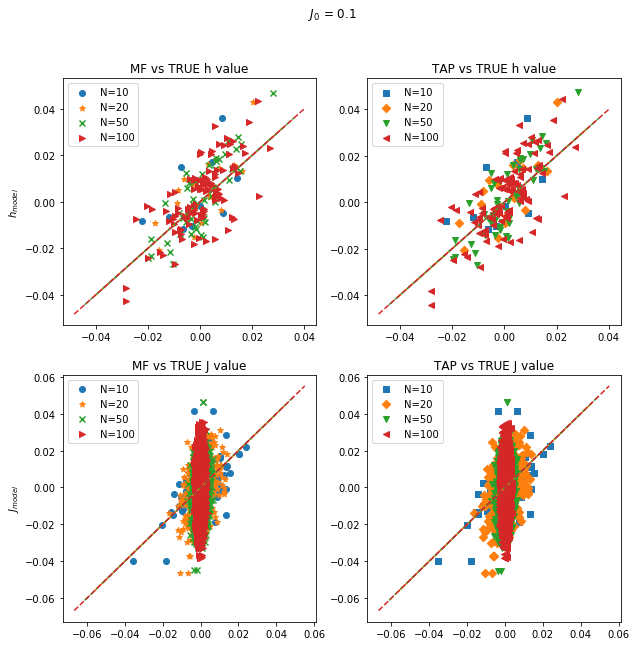

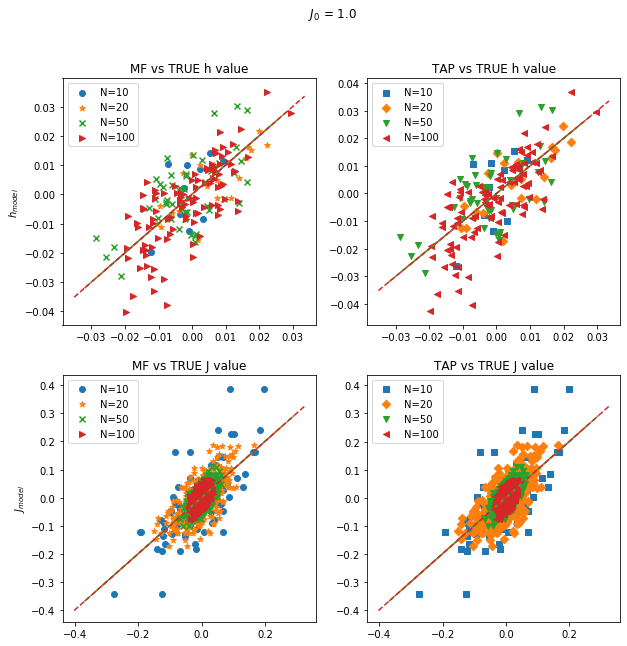

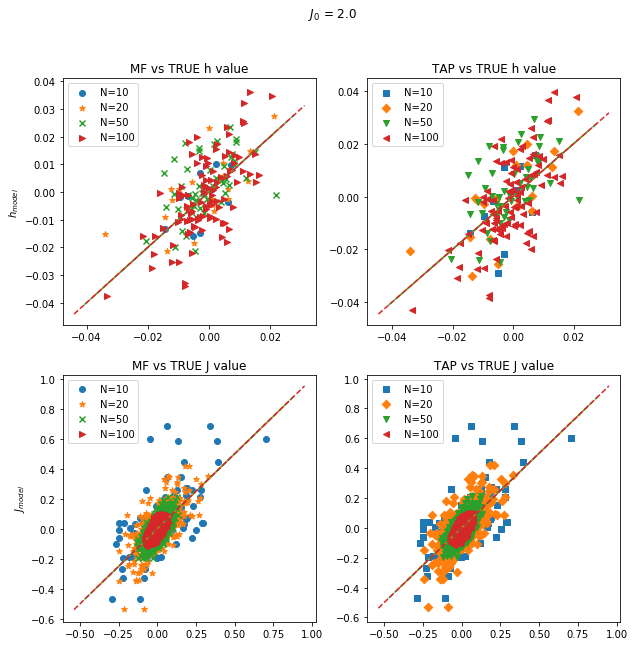

In [140]:
markers=['o','s','*','D','x','v','>','<']

for J0 in J0_values:
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    
    c=0 # for choosing the marker
    for N in N_values:
        
        ax[0, 0].scatter(h_real[(J0, N)], h_estim[(J0, N, 'MF')],marker=markers[c],label=f'N={N}')
        ax[0, 0].set_title(f'MF vs TRUE h value')
        ax[0, 0].set_ylabel('$h_{model}$')
        ax[0, 0].legend()
        ax[0, 1].scatter(h_real[(J0, N)], h_estim[(J0, N, 'TAP')],marker=markers[c+1],label=f'N={N}')
        ax[0, 1].set_title(f'TAP vs TRUE h value')
        ax[0, 1].legend()
        
        mask = np.ones(J_real[(J0, N)].shape, dtype=bool) # useful for neglecting the diagonal
        np.fill_diagonal(mask, 0)
        ax[1, 0].scatter(J_real[(J0, N)][mask], J_estim[(J0, N, 'MF')][mask],marker=markers[c],label=f'N={N}')
        ax[1, 0].set_title(f'MF vs TRUE J value')
        ax[1, 0].set_ylabel('$J_{model}$')
        ax[1, 0].legend()
        ax[1, 1].scatter(J_real[(J0, N)][mask], J_estim[(J0, N, 'TAP')][mask],marker=markers[c+1],label=f'N={N}')
        ax[1, 1].set_title(f'TAP vs TRUE J value')
        ax[1, 1].legend()
        
        c+=2
        # plot y = x line 
        for i in (0, 1):
            for j in (0, 1):
                x = np.linspace(*ax[i, j].get_xlim())
                ax[i, j].plot(x, x, '--')
        fig.suptitle(f'$J_0$ = {J0}')

## Points e) and f)
 -  Calculate RMSE between inferred and ground-truth values of the parameters.
 - Generate plots with RMSE as a function of $N$ for the 3 different $J_{0}$ values (using different markers' type). We have a total of 2 plots, one per parameter $J$ or $h$.

In [141]:
def rmse(real, estim,flag_mask=False):
    if flag_mask is False:
        return np.sqrt( np.sum((real.flatten() - estim.flatten()) ** 2))
    else:
        mask = np.ones(real.shape, dtype=bool) # useful for neglecting the diagonal
        np.fill_diagonal(mask, 0)
        return np.sqrt( np.sum((real[mask].flatten() - estim[mask].flatten()) ** 2))

In [144]:
markers=['o','s','*','D','x','v']
%matplotlib inline

Text(0, 0.5, '$RMSE_{GT,model}(h)$')

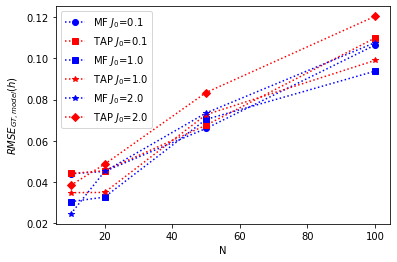

In [145]:
'''
Plot for h
'''
plt.figure()
c=0
for J0 in J0_values:  
    mf_h_rsme = [rmse(h_real[(J0, N)], h_estim[(J0, N, 'MF')]) for N in N_values]
    tap_h_rsme =[rmse(h_real[(J0, N)], h_estim[(J0, N, 'TAP')]) for N in N_values]# FILL
    
    plt.plot(N_values, mf_h_rsme,color='b', linestyle=':',label=r'MF $J_0$='+str(J0),marker=markers[c])
    plt.plot(N_values, tap_h_rsme,color='r', linestyle=':',label=r'TAP $J_0$='+str(J0),marker=markers[c+1])
    
    c+=1
plt.legend()  
plt.xlabel('N')
plt.ylabel(r'$RMSE_{GT,model}(h)$')

Text(0, 0.5, '$RMSE_{GT,model}(J)$')

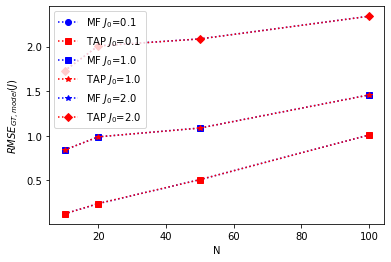

In [147]:
'''
Plot for J
'''
plt.figure()
c=0
for J0 in J0_values:  
    mf_J_rsme = [rmse(J_real[(J0, N)], J_estim[(J0, N, 'MF')],flag_mask=True) for N in N_values]
    tap_J_rsme = [rmse(J_real[(J0, N)], J_estim[(J0, N, 'TAP')],flag_mask=True) for N in N_values]# FIll
    
    plt.plot(N_values, mf_J_rsme,color='b', linestyle=':',label=r'MF $J_0$='+str(J0),marker=markers[c])
    plt.plot(N_values, tap_J_rsme,color='r', linestyle=':',label=r'TAP $J_0$='+str(J0),marker=markers[c+1])
    
    c+=1
plt.legend()  
plt.xlabel('N')
plt.ylabel(r'$RMSE_{GT,model}(J)$')

## Point g)
 - Plot $\bar{J}$ and $\bar{h}$ as a function of $N$, where $\bar{J}$ is the average over the $i,j$. Similar for $\bar{h}$. In this plot there should be 3 different curves: one for the ground-truth, one for MF and one for the TAP.


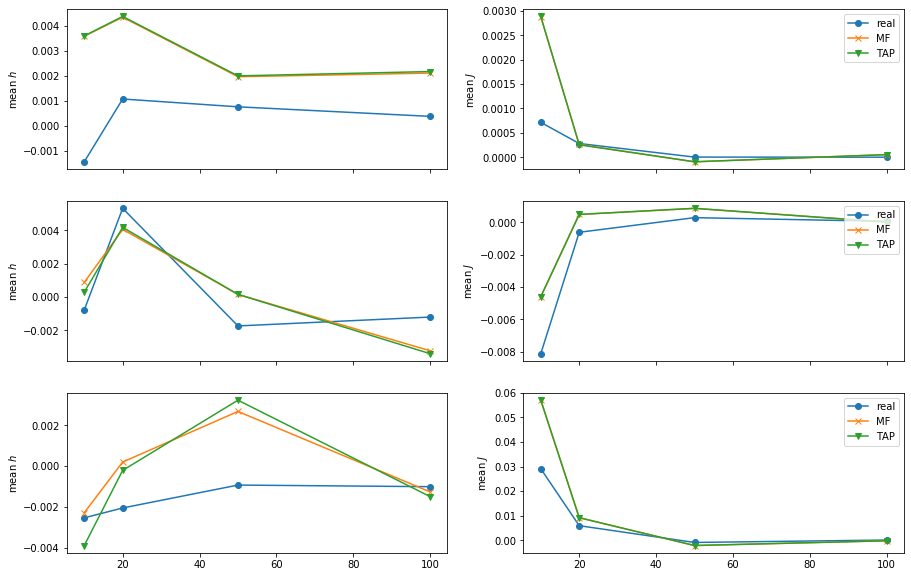

In [149]:
fig, axes = plt.subplots(len(J0_values), 2, figsize=(15, 10), sharex=True)
for i, J0 in enumerate(J0_values):
    mf_h = [np.mean(h_estim[(J0, N, 'MF')]) for N in N_values]
    mf_J = [np.mean(J_estim[(J0, N, 'MF')]) for N in N_values]
    tap_h = [np.mean(h_estim[(J0, N, 'TAP')]) for N in N_values]# FILL
    tap_J = [np.mean(J_estim[(J0, N, 'TAP')]) for N in N_values]# FILL
    real_h = [np.mean(h_real[(J0, N)]) for N in N_values]# FILL
    real_J = [np.mean(J_real[(J0, N)]) for N in N_values]# FILL
    axes[i, 0].plot(N_values, real_h, 'o-', N_values, mf_h, 'x-', N_values, tap_h, 'v-')
    axes[i, 0].set_ylabel(r'mean $h$')
    axes[i, 1].plot(N_values, real_J, 'o-', N_values, mf_J, 'x-', N_values, tap_J, 'v-')
    axes[i, 1].set_ylabel(r'mean $J$')
    axes[i, 1].legend(['real', 'MF', 'TAP'], loc='upper right')

## Point h)
- Same plot but for the variances $ \bar{h^{2}}-\bar{h}^{2}$ and $ \bar{J^{2}}-\bar{J}^{2}$.

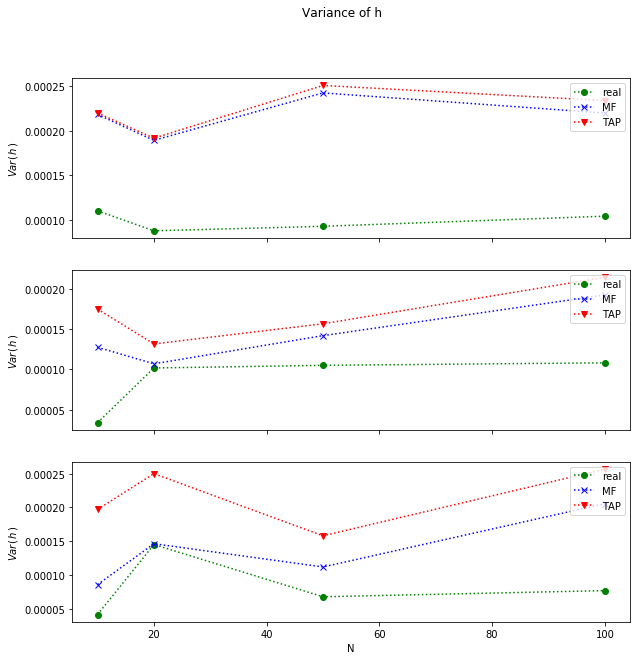

In [172]:
fig, axes = plt.subplots(len(J0_values), figsize=(10, 10), sharex=True)
for i, J0 in enumerate(J0_values):
    mf_h_var = ( np.array([np.mean(h_estim[(J0, N, 'MF')]**2) for N in N_values]) - 
               np.array([np.mean(h_estim[(J0, N, 'MF')]) for N in N_values])**2 )
    
    tap_h_var = ( np.array([np.mean(h_estim[(J0, N, 'TAP')]**2) for N in N_values]) - 
               np.array([np.mean(h_estim[(J0, N, 'TAP')]) for N in N_values])**2 )
    
    real_h_var = ( np.array([np.mean(h_real[(J0, N)]**2) for N in N_values]) - 
               np.array([np.mean(h_real[(J0, N)]) for N in N_values])**2 )
    
    axes[i].plot(N_values, real_h_var, 'o:g', N_values, mf_h_var, 'x:b', N_values, tap_h_var, 'v:r')
    axes[i].set_ylabel(r'$Var(\, h\, )$')
    axes[i].legend(['real', 'MF', 'TAP'], loc='upper right')
axes[-1].set_xlabel('N')
_ = fig.suptitle('Variance of h')

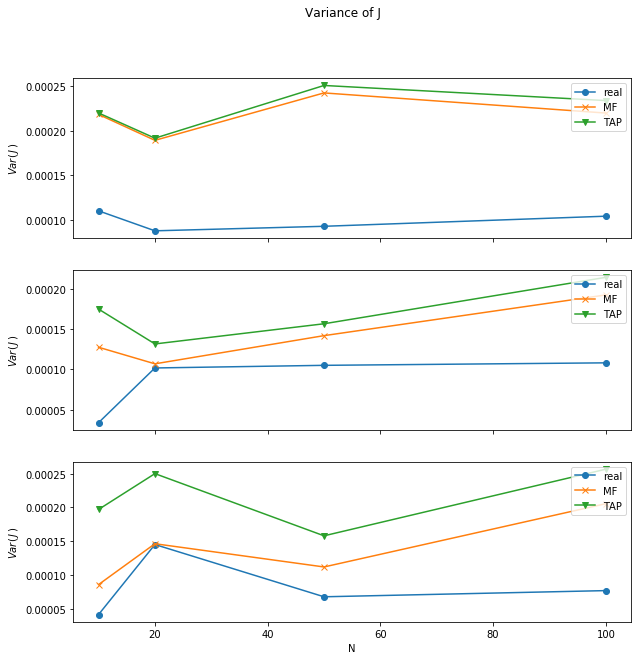

In [173]:
fig, axes = plt.subplots(len(J0_values), figsize=(10, 10), sharex=True)
for i, J0 in enumerate(J0_values):
    mf_J_var = ( np.array([np.mean(h_estim[(J0, N, 'MF')]**2) for N in N_values]) - 
               np.array([np.mean(h_estim[(J0, N, 'MF')]) for N in N_values])**2 )
    
    tap_J_var = ( np.array([np.mean(h_estim[(J0, N, 'TAP')]**2) for N in N_values]) - 
               np.array([np.mean(h_estim[(J0, N, 'TAP')]) for N in N_values])**2 )
    
    real_J_var = ( np.array([np.mean(h_real[(J0, N)]**2) for N in N_values]) - 
               np.array([np.mean(h_real[(J0, N)]) for N in N_values])**2 )
    
    axes[i].plot(N_values, real_J_var, 'o-', N_values, mf_J_var, 'x-', N_values, tap_J_var, 'v-')
    axes[i].set_ylabel(r'$Var(\, J\, )$')
    axes[i].legend(['real', 'MF', 'TAP'], loc='upper right')
axes[-1].set_xlabel('N')
_ = fig.suptitle('Variance of J')